# Lesson 6 "Differential Privacy for Deep Learning" project with MNIST (WIP)

## Note. This notebook is not final. The finished project without MNIST is in 'Section 3 - Project simple.ipynb'

## Scenario description 


Training set: 60000 labeled images. This will be split in 20 slices of 3000 labeled images to generate the private models.
Test set: 10000 images.
The test set will have 2 purposes:
 - To help measure the training accuracy (using its labels for this)
 - To act as the "public dataset", by ignoring its labels. This is the main purpose of the testset
 
 Steps

- 1) Train the 20 private models with the trainset
- 2) Use the 20 partner models to predict on the local dataset (the testset), generating 20 labels for each of the datapoints
- 3) Then, for each local data point (now with 20 labels), perform a maxcount query to get the most frequent label across the 20 labels. 
- 4) Add laplacian noise to the maxcounts to make this Differentially Private to a certain epsilon/delta constraint.
- 5) Finally, we will retrain a new model on our local dataset which now has labels (the noised ones). This will be our final "DP" model.
- 5) Do the PATE analysis to find the total epsilon used.

# Project implementation

This project will use the MNIST dataset, provided below.

In [1]:
# import torchvision.datasets as datasets
from torchvision import transforms, datasets

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor()
    ###transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [2]:
train_data = mnist_trainset.data
train_targets = mnist_trainset.targets

In [3]:
test_data = mnist_testset.data
test_targets = mnist_testset.targets

In [4]:
#mnist_trainset.test_data.sum() == mnist_trainset.train_data.sum() True
#mnist_testset.test_data.sum() == mnist_testset.train_data.sum() True
#mnist_testset.test_data.shape

In [5]:
train_data.shape

torch.Size([60000, 28, 28])

In [6]:
test_data.shape

torch.Size([10000, 28, 28])

In [7]:
len(mnist_trainset)

60000

In [8]:
import torch as th
import syft as sy
hook = sy.TorchHook(th)

In [9]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

print('Device: ', torch.device("cuda" if torch.cuda.is_available() else "cpu"))
class MnistClassifier(nn.Module):
    def __init__(self, worker = None):
        super().__init__()       
        
        self.fc1 = nn.Linear(784, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)                        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
        self.criterion = nn.NLLLoss()
        
        if worker:
            self.send(worker)
            self.is_remote = True
        else:
            self.is_remote = False        
            
        print('is_remote', self.is_remote)    

        # Use GPU if it's available
        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #self.to(device);
        
    def get_device(self):
        return "cuda" if next(self.parameters()).is_cuda else "cpu"
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))        
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
    
    def process_batch(self, inputs, labels):
        model = self
        #print('  batch: ', batch_number)
        # start = self.log_time_and_reset(start, "    Get batch:", profile)
        # batch_number += 1                
        # start = time.time() #Added by Edgarin
        
        # start = self.log_time_and_reset(start, "    Move to device:", profile)        

        log_ps = model.forward(inputs)
        # start = self.log_time_and_reset(start, "    model.forward(): ", profile)
        loss = self.criterion(log_ps, labels)
        # print('loss.location: ', loss.location)
        return (log_ps, loss)
    
    def train_dataset(self, trainloader):
        model = self
        optimizer = optim.Adam(model.parameters(), lr=0.003)
        # print('model parameters: ', list(model.parameters()))
        # print('model state_dict: ', model.state_dict())
        train_loss = 0
        for images, labels in trainloader:
            print('batch')
            if self.is_remote: images, labels = images.send(self.location), labels.send(self.location)
            #images, labels = images.to(self.get_device()), labels.to(self.get_device()) # Added by Edgarin
            #print('{')
            #print('bobs objects: ', model.location._objects)
            optimizer.zero_grad()
            #print('}')
            (log_ps, loss) = self.process_batch(images, labels)
            loss.backward()
            optimizer.step()            
            # start = self.log_time_and_reset(start, "    backward and step: ", profile)
            train_loss += loss            
        return (train_loss)
    
    def predict_dataset(self, testloader, isValidation = False, return_predictions = False):
        model = self
        test_loss = 0
        accuracy = 0
        
        predictions = torch.tensor([]).long()

        # Turn off gradients for validation, saves memory and computations                
        with torch.no_grad():            
            if isValidation: model.eval()  # To activate dropouts
            for images, labels in testloader:
                #start = time.time() #Added by Edgarin
                if self.is_remote: images, labels = images.send(self.location), labels.send(self.location)
                #images, labels = images.to(self.get_device()), labels.to(self.get_device()) # Added by Edgarin
                
                (log_ps, loss) = self.process_batch(images, labels)
                
                test_loss += loss

                ps = torch.exp(log_ps)
                
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                # accuracy += torch.mean(equals.type(torch.FloatTensor))
                print('batch accuracy: ', torch.mean(equals.float()).get())
                accuracy += torch.mean(equals.float())
                
                #print(f"Device = {self.get_device()}; Last test batch time: {(time.time() - start):.4f} seconds") #Added by Edgarin
                
                if return_predictions:
                    prediction = top_class.view(top_class.shape[0]).cpu()
                    predictions = torch.cat((predictions, prediction), 0)
            else:
                model.train()        
        return (accuracy, test_loss, predictions if return_predictions else None)
    
  
    def log_time_and_reset(self, start, message = "{:.4f} seconds", profile = False):
        new_start = time.time()
        if profile: print((message + " {:.0f} ms").format((new_start - start)*1000)) #Added by Edgarin
        return new_start
    
    
    def train_and_test(self, trainloader, testloader, epochs = 1, profile = False):        
        model = self                        

        # epochs = 30  #Only thing changed from original
        steps = 0

        train_losses, test_losses = [], []
        for e in range(epochs):
            print('Epoch {}'.format(e+1))
            b = 0
            epoch_start = time.time()
            start = time.time()
            (train_loss) = self.train_dataset(trainloader)
            train_loss = train_loss
                        
            #else:
            if profile: print(f"  Epoch time: {(time.time() - epoch_start):.4f} seconds") #Added by Edgarin
            if(False):                
                ###
                (accuracy, test_loss, _) = self.predict_dataset(testloader, isValidation = True)
                accuracy = accuracy.get() ###Temp
                test_loss = test_loss.get() ###Temp
                
                train_losses.append(train_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))

                print("Epoch: {}/{} ".format(e+1, epochs),
                      "Training Loss: {:.3f} ".format(train_loss/len(trainloader)),
                      "Test Loss: {:.3f} ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                #print("len(trainloader)", len(trainloader))
                #print("train_loss", train_loss)
                #print("train_loss/len(trainloader)", train_loss/len(trainloader))
                
                
                #print("Epoch: {}/{} ".format(e+1, epochs))
                #print("Training Loss: {:.3f} ".format(train_loss/len(trainloader)))
                #print("Test Loss: {:.3f} ".format(test_loss/len(testloader)))
                #print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Classifier = MnistClassifier    

Device:  cuda


In [10]:
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=16384, shuffle=False)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=8192, shuffle=False)


In [18]:
bob = sy.VirtualWorker(hook, id="bob8")


In [12]:
bob.clear_objects()
modelBob = Classifier(bob)
#print(modelBob.location)
#print('Bob objects before training: ', bob._objects)


is_remote True


In [13]:
modelBob.train_and_test(trainloader, testloader, 3)

Epoch 1
batch
batch
batch
batch
Epoch 2
batch
batch
batch
batch
Epoch 3
batch
batch
batch
batch


In [14]:
#import mnist_classifier
#Classifier = mnist_classifier.MnistClassifier
bob._objects

{21591714816: Parameter containing:
 tensor([[-266645.6562, -266645.6250, -266645.6875,  ..., -266645.6875,
          -266645.6562, -266645.6250],
         [-266645.6250, -266645.6875, -266645.6875,  ..., -266645.6562,
          -266645.6250, -266645.6250],
         [-266645.6875, -266645.6875, -266645.6562,  ..., -266645.6875,
          -266645.6562, -266645.6562],
         ...,
         [-266645.6875, -266645.6250, -266645.6250,  ..., -266645.6562,
          -266645.6562, -266645.6875],
         [-266645.6875, -266645.6250, -266645.6562,  ..., -266645.6562,
          -266645.6875, -266645.6250],
         [-266645.6250, -266645.6562, -266645.6250,  ..., -266645.6562,
          -266645.6250, -266645.6250]], requires_grad=True),
 9618960564: Parameter containing:
 tensor([-233148.0312, -234404.2812, -233314.3750, -233163.0938, -233141.8125,
         -233177.4375, -233159.5938, -233151.5938, -233156.7812, -233152.0625,
         -233178.0938, -233175.2188, -233134.6562, -233154.8125, -233

In [ ]:
for device in ['cpu']:  
    print('---', device, '---')
    ## Test training a model
    start = time.time()
    modelBob = Classifier(bob)
    #modelBob.to(device)    
    modelBob.train_and_test(trainloader, testloader, 5)
    print(f"Device = {modelBob.get_device()}; Whole time: {(time.time() - start):.4f} seconds") #Added by Edgarin
print('done')    


--- cpu ---
is_remote True
Epoch 1
batch
batch
batch
batch
batch accuracy:  tensor(0.0903)
batch accuracy:  tensor(0.0841)
Epoch: 1/5  Training Loss: 2.645  Test Loss: 2.780  Test Accuracy: 0.087
Epoch 2
batch
batch
batch
batch
batch accuracy:  tensor(0.0903)
batch accuracy:  tensor(0.0841)
Epoch: 2/5  Training Loss: 2.785  Test Loss: 2.805  Test Accuracy: 0.087
Epoch 3


tensor(1.)


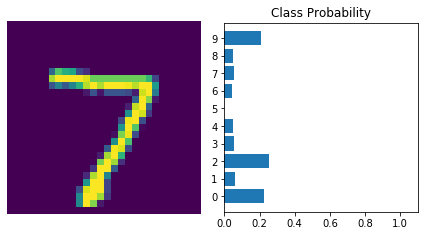

In [17]:
%matplotlib inline
import helper

images, labels = next(iter(testloader))
img = images[0] #.view(1, 784)
if modelBob.is_remote: img = img.send(bob)
# Turn off gradients to speed up this part
with torch.no_grad():
    #logps = modelBob.forward(img.to(model1.get_device())).cpu()
    logps = modelBob.forward(img)
    print(torch.exp(logps).sum().get())

# Output of the network are logits, need to take softmax for probabilities
ps = torch.exp(logps)
if modelBob.is_remote: 
    helper.view_classify(img.get().view(1, 28, 28), ps.get())
else:
    helper.view_classify(img.view(1, 28, 28), ps)


In [ ]:
from torch.utils.data import SubsetRandomSampler 

def get_trainloader_slice(i, slice_size):    
    train_indices = range(int(i*slice_size), int((i+1)*slice_size))
    trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=512, shuffle=False, sampler=SubsetRandomSampler(train_indices))
    return trainloader

models = list()
train_size = len(mnist_trainset)
n_teachers = 200
n_slices = n_teachers  #n_slices is deprecated
slice_size = train_size / n_slices

for i in range(n_slices):
    print('----- Training slice ', i, '... -----')
    new_model = Classifier()
    # print('is_cuda', next(new_model.parameters()).is_cuda)
    new_trainloader = get_trainloader_slice(i, slice_size)
    new_model.train_and_test(new_trainloader, testloader, 3)
    models.append(new_model)    
len(models)


In [ ]:
n_testset = len(mnist_testset)
with torch.no_grad():    
    private_label_matrix = torch.zeros(len(models), n_testset).long()
    for i in range(len(models)):
        model = models[i]
        # predictions = model.predict_dataset(testloader)        
        predictions = predict_dataset(model, testloader)        
        private_label_matrix[i] = predictions
    print(private_label_matrix.shape)

In [ ]:
import numpy as np
def getLaplacianNoise(sensitivity, epsilon):
    b = sensitivity / epsilon
    return np.random.laplace(0, b, 1)

In [ ]:
dp_labels = torch.zeros(n_testset).long()
epsilon = 0.1
sensitivity = 1
nondp_labels = torch.zeros(n_testset).long()
for i in range(n_testset):
    private_labels = private_label_matrix[:,i].bincount(minlength=10)
    
    # print(private_labels.tolist())
    noised_labels = list(map(lambda l: l + getLaplacianNoise(sensitivity, epsilon)[0], private_labels.tolist()))
  
    dp_labels[i] = int(np.argmax(noised_labels))
    nondp_labels[i] = int(np.argmax(private_labels.tolist()))

dp_labels
nondp_labels

In [ ]:
## Test accuracy
equals = dp_labels == mnist_testset.targets
accuracy = torch.mean(equals.type(torch.FloatTensor))    
print('DP model accuracy: ', accuracy)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# mnist_testset.test_data.shape
# torch.Size([10000, 28, 28])
images = mnist_testset.data.float() / 255  # Needed for normalization

dataset = TensorDataset(images, dp_labels.long())
dploader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
dpmodel = Classifier()
dpmodel.train_and_test(dploader, testloader, 8)


In [ ]:
from syft.frameworks.torch.differential_privacy import pate

data_dep_eps, data_ind_eps = pate.perform_analysis(
    teacher_preds=private_label_matrix.numpy().astype(int), 
    indices=nondp_labels.numpy().astype(int), 
    noise_eps=0.1, 
    delta=1e-5,
    #moments=100
)

# assert data_dep_eps <= data_ind_eps

In [ ]:
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)